In [20]:
import numpy as np
import astropy.units as u
from gmagaox.math_module import xp, ensure_np_array
import matplotlib.pyplot as plt

import poppy

wavelength = 650*u.nm
diam = 25.4*u.m
npix = 4096

wf = poppy.FresnelWavefront(beam_radius=diam/2, npix=npix, oversample=1)

def psd_model(k, psd_parm):
    # k: array/matrix of spatial frequencies
    # psd_parm: list with the PSD parameters
    alpha = psd_parm[0]
    beta = psd_parm[1]
    oscl = psd_parm[2]
    iscl = psd_parm[3]
    bsr = psd_parm[4]
    if oscl.value != 0:
        denom = ( ((1/oscl)**2) + (k**2))**(alpha/2)
    else: # explosion prevention
        denom = (k**2)**(alpha/2)
    pk = ((beta/denom) * np.exp(-((k.value*iscl)**2))) + bsr
    return pk


Oversampling > 2x suggested for reliable results in Fresnel propagation.


Text(0.5, 1.0, 'Example PSD distribution')

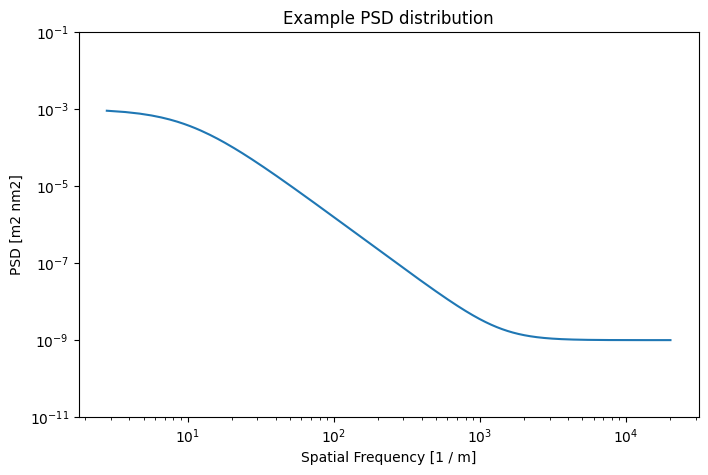

In [17]:
alpha = 2.8
psd_params = {
    'alpha':alpha,
    'beta':0.637*u.nm**2 / (u.m**(alpha-2)),
    'outer_scale':0.1*u.m,
    'inner_scale':1e-4,
    'surf_roughness':1e-9 * u.m**2 * u.nm**2,
}

psd_list = [[psd_params['alpha'], psd_params['beta'],
             psd_params['outer_scale'], psd_params['inner_scale'], psd_params['surf_roughness']]]
psd_weight = [1]
incident_angle = 0*u.degree

seed = 123456
screen_size = int(npix*1)

k_range = (np.arange(start=2.8, stop=20176, step=0.95)/u.m)
psd1 = psd_model(k_range, psd_list[0])

plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value)
plt.ylim(top=0.1, bottom=1e-11)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('Example PSD distribution')


In [ ]:
diam = 6.5*u.mm

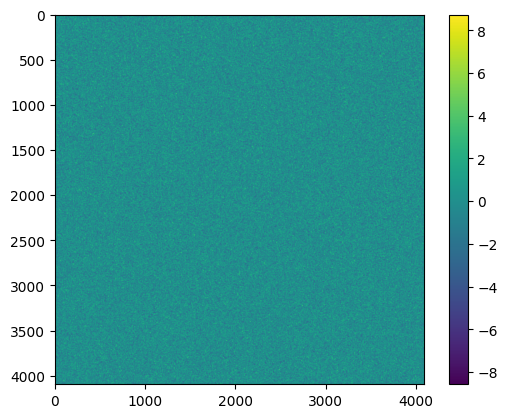

In [21]:

wfe = poppy.PowerSpectrumWFE(psd_parameters=psd_list, 
                             psd_weight=psd_weight,
                             incident_angle=incident_angle,
                             apply_reflection=True,
                             seed=seed, 
                             screen_size=screen_size,
                            )

psd_opd = wfe.get_opd(wf)*1e9

plt.imshow(ensure_np_array(psd_opd))
plt.colorbar()